# Quinta lista - Problema grupal 3

## Componentes del grupo

* Pol Casacuberta Gil
* Joaquin Faraone Prieto
* Agnès Felip i Díaz
* Marta Granero I Martí

## Sumemos de nuevo

## Los resultados del experimento de suma usando k-vecinos más cercanos fueron un poco decepcionantes incluso transformando los atributos para una mejor representación. Las relaciones no lineales entre algunos atributos fueron las culpables de estos resultados no óptimos. Ahora que conocemos otros clasificadores, podemos probar si pueden hacer un mejor trabajo.

## El escenario será el mismo, aprendiendo a sumar números de tres dígitos con ejemplos definidos por seis atributos, los tres primeros atributos corresponden a los tres dígitos del primer número y los tres últimos a los dígitos del segundo número. La salida tiene cuatro valores, uno para cada dígito para cada número del resultado de la suma. Por ejemplo:

|X1|X2|X3|X4|X5|X6|Y1|Y2|Y3|Y4|
|--|--|--|--|--|--|--|--|--|--|
|0 |1 |6 |4 |7 |7 |0 |4 |9 |3 |


### Procedemos a realizar los ejercicios que se nos piden

#### Incluimos las librerias necesarias

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import  ConfusionMatrixDisplay,classification_report,\
                             RocCurveDisplay, PrecisionRecallDisplay,\
                             accuracy_score, f1_score, precision_score, recall_score

from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Binarizer
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC

from IPython.display import display, HTML #core.display deprecated
show_html = lambda html: display(HTML(html))

from yellowbrick.target.feature_correlation import feature_correlation
from yellowbrick.classifier import precision_recall_curve
from yellowbrick.classifier.rocauc import roc_auc

import random
import itertools
from itertools import permutations

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Definimos los atributos que tendran los datasets

In [3]:
columns      = ["X1", "X2", "X3", "X4", "X5", "X6", "Y1", "Y2", "Y3", "Y4"]
data_columns = ["X1", "X2", "X3", "X4", "X5", "X6"]
y_columns    = ["Y1", "Y2", "Y3", "Y4"]

#### Creación de los datasets

In [4]:
#Function to create array
def prepareArray(number, size):
    X1 = list(map(int, str(number)))
    while len(X1) < size:
        X1.insert(0,0)
    return X1
    
def setFormat(first,second):
    total = first+second
    X1 = prepareArray(first,3)
    X2 = prepareArray(second,3)
    Y  =  prepareArray(total,4)
    return X1+X2+Y

def createDataset(n, seed=42):
    np.random.seed(seed)
    firsts = np.random.randint(0, 999, size=n)
    seconds= np.random.randint(0, 999, size=n)
    matrix = []
    
    for first, second in zip(firsts,seconds):
        matrix.append(setFormat(first,second))

    data = pd.DataFrame(matrix, columns=columns)
    data = data.drop_duplicates()
    
    return data

def createDataset_p(n, seed=42):
    """
    This method makes absolutely sure that we create exactly n 
    examples for the dataset, so that the datasets are strictly greater than each other.
    """
    max_number = 999
    np.random.seed(seed)
    random.seed(seed)
    values = np.linspace(0, max_number, 1000, dtype=int)
    unique_permutations = set(permutations(values, 2))

    samples = random.sample([*unique_permutations], k=n)  # picks k number of numbers from 0 to n without replacement
    matrix = []
    for sample in samples:
        matrix.append(setFormat(sample[0], sample[1]))
    data = pd.DataFrame(matrix, columns=columns)
    data = data.drop_duplicates()
    return data

### a)  Dado que vamos a utilizar clasificadores más potentes, probablemente necesitemos menos ejemplos para funcionar mejor, así que generad dos conjuntos de datos de 25.000 y 50.000 ejemplos. Dividid los conjuntos de datos en un conjunto de test y entrenamiento con una proporción de 90 %/10 %

#### Generamos los dos conjuntos de datos de 25.000 i 50.000 ejemplos

In [5]:
dataset0 = 25000
dataset1 = 50000

dataset0 = pd.DataFrame(createDataset_p(dataset0))
dataset1 = pd.DataFrame(createDataset_p(dataset1))

#### Dividimos los conjuntos de datoes en un conjunto de entrenamineto y test con una proporción de 90%/10% respectivamente

In [6]:
X_train_0, X_test_0 = train_test_split(dataset0, test_size=0.1, random_state=42, shuffle=True)
X_train_1, X_test_1 = train_test_split(dataset1, test_size=0.1, random_state=42, shuffle=True)

y_train_0 = X_train_0[y_columns]
X_train_0 = X_train_0.drop(y_columns, axis=1)
y_test_0 = X_test_0[y_columns]
X_test_0 = X_test_0.drop(y_columns, axis=1)

y_train_1 = X_train_1[y_columns]
X_train_1 = X_train_1.drop(y_columns, axis=1)
y_test_1 = X_test_1[y_columns]
X_test_1 = X_test_1.drop(y_columns, axis=1)

### b) Como recordaréis, este es un problema de clasificación de salida múltiple, por lo que necesita usar el objeto $\texttt{MultiOutputClassifier}$ de scikit learn. Esto envolverá los clasificadores para que pueda realizar este tipo de clasificación.

### Usad $\texttt{SVC}$ para la clasificación con un kernel rbf con diferentes valores para $\texttt{C}$. Podéis usar diferentes potencias de 10 para ese parámetro para ver dónde está el mejor acierto para los datos de test en lugar de usar validación cruzada, os tardará mucho si la usáis. Aseguraos de usar el parámetro $\texttt{n\_jobs}$ de los objetos de clasificación de salida múltiple para que las cosas se hagan en paralelo.

Para cada conjunto de datos calcularemos los pares de valores: (C,score) para ver cuál valor para el parámetro C nos da el mejor acierto para los datos del conjunto de test.

#### Para el primer conjunto de datos (dataset0)

In [7]:
regularization_c = [10**i for i in range(7)]

resultados_dataset0 = [    
    (r_c, MultiOutputClassifier(SVC(C=r_c,kernel='rbf',random_state=42),n_jobs=-1).fit(X_train_0,y_train_0).score(X_test_0,y_test_0)) for r_c in regularization_c]

print(resultados_dataset0)

[(1, 0.594), (10, 0.934), (100, 0.9584), (1000, 0.964), (10000, 0.9592), (100000, 0.9592), (1000000, 0.9592)]


In [8]:
list_of_values_0 = list(map(lambda x: x[1], resultados_dataset0))
list_of_values_0

[0.594, 0.934, 0.9584, 0.964, 0.9592, 0.9592, 0.9592]

#### Para el primer conjunto de datos (dataset1)

In [9]:
regularization_c = [10**i for i in range(7)]

resultados_dataset1 = [    
    (r_c, MultiOutputClassifier(SVC(C=r_c,kernel='rbf',random_state=42),n_jobs=-1).fit(X_train_1,y_train_1).score(X_test_1,y_test_1)) for r_c in regularization_c]

print(resultados_dataset1)

[(1, 0.7878), (10, 0.966), (100, 0.9856), (1000, 0.989), (10000, 0.9836), (100000, 0.9836), (1000000, 0.9836)]


In [10]:
list_of_values_1 = list(map(lambda x: x[1], resultados_dataset1))
list_of_values_1

[0.7878, 0.966, 0.9856, 0.989, 0.9836, 0.9836, 0.9836]

#### Mejores score del dataset0

Calculamos para cada dataset su score correspondiente usando el mejor parámetro C obtenido para en la lista de valores que hemos obtenido arriba.

In [12]:
def calculate_score(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    return classifier.score(X_test, y_test)

In [13]:
r_c = 1000
classifier = MultiOutputClassifier(SVC(C=r_c,kernel='rbf',random_state=42),n_jobs=-1)
score = calculate_score(classifier, X_train_0, y_train_0, X_test_0, y_test_0)
score

0.964

Obtenemos el mejor score del modelo con el parámetro de regularización **C=1000**.

#### Mejores score del dataset1

In [14]:
r_c = 1000
classifier = MultiOutputClassifier(SVC(C=r_c,kernel='rbf',random_state=42),n_jobs=-1)
score = calculate_score(classifier, X_train_1, y_train_1, X_test_1, y_test_1)
score

0.989

Asimismo para este dataset, también obtenemos el mejor score del modelo con el parámetro de regularización **C=1000**

#### Ploteamos los resultados obtenidos

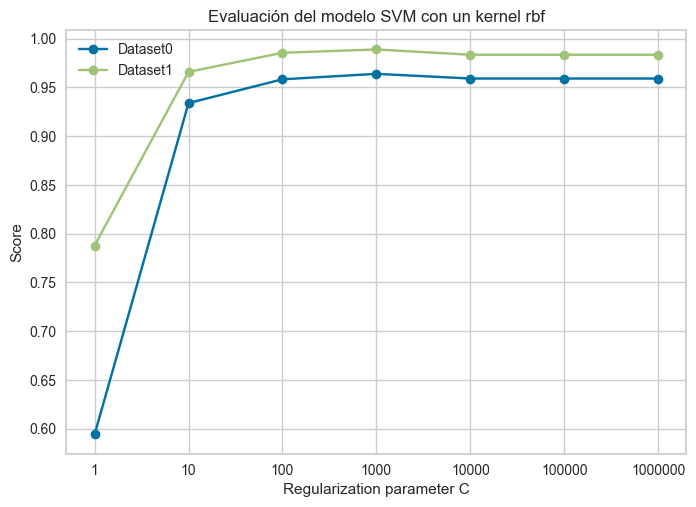

In [11]:
x_values = range(len(regularization_c))
x_label = "Regularization parameter C"
y_label = "Score"
title = "Evaluación del modelo SVM con un kernel rbf"
legend_labels = ['Dataset0', 'Dataset1']

plt.plot(list_of_values_0, marker="o")
plt.plot(list_of_values_1, marker="o")
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)
plt.legend(legend_labels)
plt.xticks(x_values, regularization_c)
plt.show()

Tal y como podemos ver en el gráfico anterior, para ambos datasets tenemos un acierto muy parecido y muy bueno. Tanto para el dataset0 como para el dataset1, obtenemos la mejor precisión con el parámetro de regularización C=1000.

Con el parámetro **C=1000** y el dataset0 obtenemos una precisión del **96.4%** y con el dataset1, y el mismo parámetro **C=1000**, obtenemos una precisión del **98.9%**. 

Esos resultados que hemos obtenido son de lejos mucho mejores que los que obtuvimos con los modelos KNN usando one-hot-encoding. En estos modelos obtuvimos una precisión de alreador el **80%**, dónde la mayor precisión que logramos alcanzar fue con la métrica **l1** usando como peso **la distáncia** y con **100 vecinos** logrando un score que superaba el **85%**.

Sin usar one-hot-encoding y para cualesquiera de las **métricas(['l2','l1'])**, **pesos(['distance','uniform'])** y para cualquier **número de vecinos** considerados **([10,50,100,500])**, teníamos una precision de entre el **20-55%**.

### c) Usad $\texttt{GradientBoostingClassifier}$ con diferentes valores para el número de estimadores y la profundidad máxima de los árboles. La cantidad de estimadores no tiene que ser muy grande, pero probablemente necesitaréis alrededor de 50 árboles con la tasa de aprendizaje predeterminada. Además, los árboles demasiado poco profundos darán malos resultados. Evaluad el acierto sobre el test como en el apartado anterior.

### Podéis acceder a los clasificadores individuales del clasificador de salida múltiple con el atributo $\texttt{estimator\_}$. Obtened la importancia de los atributos para cada clasificador que encontraréis en el atributo $\texttt{feature\_importances}$ e interpretad los resultados.

A continuación usaremos diferentes valores para el número de estimadores y para la profundida máxima de los árboles tanto para el primer(dataset0) como para el segundo dataset(dataset1). 

Los valores que hemos escogido han sido despúes de realizar varias pruebas ya que nos dimos cuenta que si probabamos un número muy grande de estimadores y muchos valores para la profundidad máxima, nuestro código tardaba horas en dar el resultado. Ahora con estos valores tarda alrededor de una hora para el dataset0. Y alrededor de un poco más del doble para el dataset1

#### Para el dataset0

In [15]:
estimators = [5, 10, 20, 30, 50, 70, 100]
max_depths = [None, 1, 2, 3, 5, 8, 10, 20]

resultados = [
    (estimator, 
     [MultiOutputClassifier(GradientBoostingClassifier(n_estimators=estimator, max_depth=m_d),
                            n_jobs=-1).fit(X_train_0, y_train_0).score(X_test_0, y_test_0) for m_d in max_depths])
    for estimator in estimators
]
print(resultados)

[(5, [0.3396, 0.0008, 0.0044, 0.0168, 0.0488, 0.2172, 0.434, 0.426]), (10, [0.3428, 0.0, 0.0092, 0.032, 0.0924, 0.4724, 0.704, 0.464]), (20, [0.34, 0.0008, 0.016, 0.0572, 0.2904, 0.7868, 0.87, 0.5364]), (30, [0.3456, 0.0016, 0.0236, 0.1232, 0.3996, 0.8588, 0.8984, 0.5892]), (50, [0.3428, 0.0008, 0.0608, 0.2108, 0.5748, 0.8808, 0.91, 0.6812]), (70, [0.3476, 0.002, 0.0984, 0.2508, 0.6932, 0.89, 0.904, 0.7608]), (100, [0.4916, 0.0024, 0.1432, 0.3048, 0.7736, 0.8896, 0.9016, 0.7848])]


Obtenemos la lista de scores para cada número diferente de estimadores:

In [16]:
list_of_values_gb = list(map(lambda x: x[1], resultados))
list_of_values_gb

[[0.3396, 0.0008, 0.0044, 0.0168, 0.0488, 0.2172, 0.434, 0.426],
 [0.3428, 0.0, 0.0092, 0.032, 0.0924, 0.4724, 0.704, 0.464],
 [0.34, 0.0008, 0.016, 0.0572, 0.2904, 0.7868, 0.87, 0.5364],
 [0.3456, 0.0016, 0.0236, 0.1232, 0.3996, 0.8588, 0.8984, 0.5892],
 [0.3428, 0.0008, 0.0608, 0.2108, 0.5748, 0.8808, 0.91, 0.6812],
 [0.3476, 0.002, 0.0984, 0.2508, 0.6932, 0.89, 0.904, 0.7608],
 [0.4916, 0.0024, 0.1432, 0.3048, 0.7736, 0.8896, 0.9016, 0.7848]]

#### Ploteamos los resultados para el dataset0

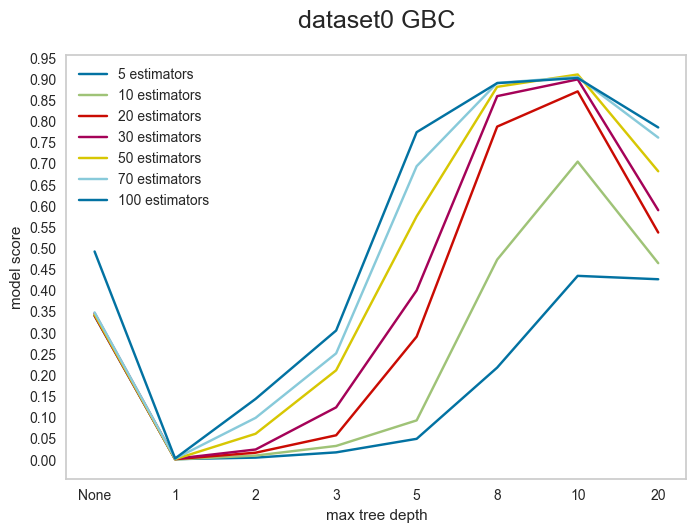

In [17]:
xvalues = np.arange(1, len(max_depths) + 1)
max_depths = [str(m_d) for m_d in max_depths]
names_estimators = [f"{estimator} estimators" for estimator in estimators]

plt.title("dataset0 GBC", fontsize=18, pad=20)
plt.xticks(xvalues, max_depths)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.ylabel("model score")
plt.xlabel("max tree depth")

for i, val in enumerate(estimators):
    plt.plot(xvalues, list_of_values_gb[i])

plt.legend(names_estimators)
plt.grid()
plt.show()

Como podemos ver si evaluamos el acierto sobre el conjunto de test como hemos hecho en el apartado anterior obtenemos el mejor score del modelo para un número de **50 estimadores y una profundida máxima del árbol de 10**. Como se puede apreciar es la línia amarilla del gráfico. Seguida de la línia azul claro, de 70 estimadores, con la misma profundidad y seguida de la línia azul oscura de 100 estimadores con una profundidad de 10 también.

Para el mejor modelo que tenemos, vemos que alcanzamos una precisión del **91%**. Seguida de una precisión del segundo mejor modelo del 90.4% i finalmente para el modelo de 100 estimadores y una profundidad de 10, una precisión del 90.16%.

Este modelo con 50 estimadores y una profundida de 10 nos parece adecuado ya que a más estimadores el tiempo de cálculo es más grande. Así que hemos de escoger un modelo en el que tengamos en cuenta tanto el tiempo, como su rendimiento ya que de nada nos sirve un buen modelo pero que su tiempo de ejecución sea muy grande y solo mejore poco su rendimiento a un modelo que tarde menos y su rendimiento sea un poco peor a este. Así pues, hemos de tener en cuenta este ratio para escoger el modelo que se ajusta mejor a nuestro deseo.


#### Mejores parámetros para el GBC modelo y accedemos a los clasificadores individuales del $\texttt{MultiOutputClassifier}$ con el atributo $\texttt{estimators\_}$

Aquí escogemos como mejores parámetros un número de estimadores igual a 50 y una profundidad máxima de los árboles de 10.

In [52]:
multi0 = MultiOutputClassifier(GradientBoostingClassifier(n_estimators=50,max_depth=10),n_jobs=-1);
multi0.fit(X_train_0,y_train_0);
multi0.estimators_

[GradientBoostingClassifier(max_depth=10, n_estimators=50),
 GradientBoostingClassifier(max_depth=10, n_estimators=50),
 GradientBoostingClassifier(max_depth=10, n_estimators=50),
 GradientBoostingClassifier(max_depth=10, n_estimators=50)]

#### Importancia de los atributos para cada clasificador usando el atributo de $\texttt{feature\_importances}$

A continuación ploteamos los resultados:

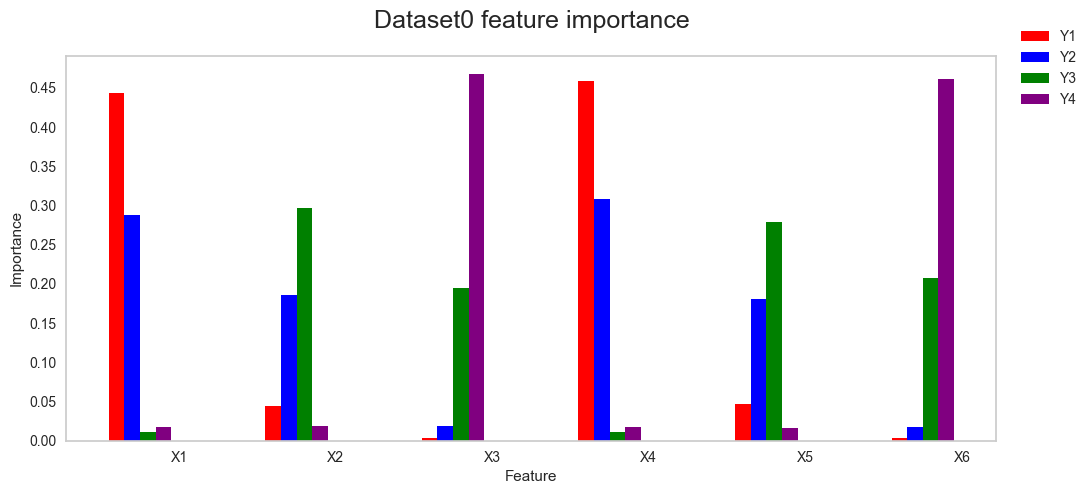

In [53]:
xvalues = np.arange(1, len(data_columns) + 1)
names_cols = list(map(str, data_columns))

fig, ax = plt.subplots(figsize=(12, 5))

ax.set_title("Dataset0 feature importance", fontsize=18, pad=20)
ax.set_xticks(xvalues + 0.3)
ax.set_xticklabels(names_cols)
ax.set_yticks(np.arange(0, 1.00, 0.05))
ax.set_ylabel("Importance")
ax.set_xlabel("Feature")

colors = ["red", "blue", "green", "purple"]
estimators_classifiers0 = multi0.estimators_
for i, val in enumerate(estimators_classifiers0):
    ax.bar(xvalues + (i - 1) * 0.1, val.feature_importances_, 0.1, color=colors[i])

ax.legend(y_columns, bbox_to_anchor=(1.1, 1.1))
plt.grid()
plt.show()

A continuación procedemos a explicar los resultados que hemos obtenido:

En primer lugar en el eje X tenemos las características (tanto el **primer(X1X2X3)**, como el **segundo número(X4X5X6)** que sumamos) y, en el eje Y, la importancia que tiene cada característica en cada clase objetivo. Además el número que resulta de sumar ambos, los guardamos en el **número resultante(Y1Y2Y3Y4)**

Cabe notar que:

* X1 y X4 son las características que hablan de las centenas
* X2 y X5 son las features que hablan de las decenas
* X3 y X6 son las features que hablan de las unidades. 

Por otro lado:

* Y1 que es el atributo que nos habla de los miles
* Y2 que es el atributo que nos habla de las centenas 
* Y3 que es el atributo que nos habla de las decenas
* Y4 que es el atributo que nos habla de las unidades.

Así que el gráfico que obtenemos es razonable ya que podemos explicar fácilmente por qué Y1 se explica principalmente mediante las características X1 y X4 del primer y segundo número respectivamente. Esto es así, ya que gracias a los distintos valores que tomen las características X1 y X4 harán que Y1 se convierta en un valor u otro. Esto es lógico, ya que si X1 y X4 son mayores o iguales que 5, Y1 será 1 y 0 en caso contrario.

Tenemos el mismo caso para el valor Y4, ya que las características, X3 y X6, consisten en las unidades de los números y luego, razonablemente, tienen casi toda la importancia para poder inferir el valor Y4.

Y2 e Y3 se comportan de manera similar a como tenemos en Y1, ya que el valor de Y2 depende del valor de X1 y X4 e X2 y X5 i.e del valor de las centenas y las decenas de los números que sumamos. Y el valor de Y3 depende del valor de las decenas y las unidades de los números que agregamos. Asimismo el valor de Y4 dependerá del valor de las unidades de los números que sumamos.

#### Para el dataset1

In [44]:
estimators = [5, 10, 20, 30, 50, 70, 100]
max_depths = [None, 1, 2, 3, 5, 8, 10, 20]

resultados = [
    (estimator, 
     [MultiOutputClassifier(GradientBoostingClassifier(n_estimators=estimator, max_depth=m_d),
                            n_jobs=-1).fit(X_train_1, y_train_1).score(X_test_1, y_test_1) for m_d in max_depths])
    for estimator in estimators
]
print(resultados)

[(5, [0.4656, 0.0006, 0.0048, 0.0182, 0.083, 0.3634, 0.6072, 0.6456]), (10, [0.4728, 0.001, 0.0106, 0.0374, 0.1834, 0.6246, 0.856, 0.7058]), (20, [0.4742, 0.0022, 0.021, 0.0678, 0.3476, 0.8476, 0.9264, 0.7976]), (30, [0.473, 0.0022, 0.0378, 0.13, 0.4672, 0.9, 0.946, 0.8524]), (50, [0.475, 0.0018, 0.0814, 0.2198, 0.645, 0.9248, 0.949, 0.899]), (70, [0.4726, 0.002, 0.1292, 0.2578, 0.7382, 0.9284, 0.9482, 0.9182]), (100, [0.6532, 0.0018, 0.1718, 0.316, 0.8208, 0.9298, 0.9402, 0.9272])]


In [45]:
list_of_values_gb = list(map(lambda x: x[1], resultados))
list_of_values_gb

[[0.4656, 0.0006, 0.0048, 0.0182, 0.083, 0.3634, 0.6072, 0.6456],
 [0.4728, 0.001, 0.0106, 0.0374, 0.1834, 0.6246, 0.856, 0.7058],
 [0.4742, 0.0022, 0.021, 0.0678, 0.3476, 0.8476, 0.9264, 0.7976],
 [0.473, 0.0022, 0.0378, 0.13, 0.4672, 0.9, 0.946, 0.8524],
 [0.475, 0.0018, 0.0814, 0.2198, 0.645, 0.9248, 0.949, 0.899],
 [0.4726, 0.002, 0.1292, 0.2578, 0.7382, 0.9284, 0.9482, 0.9182],
 [0.6532, 0.0018, 0.1718, 0.316, 0.8208, 0.9298, 0.9402, 0.9272]]

#### Ploteamos los resultados para el dataset1

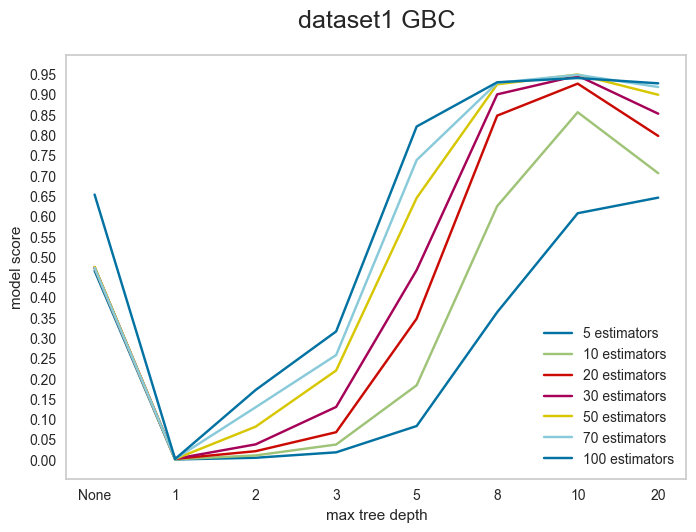

In [46]:
xvalues = np.arange(1, len(max_depths) + 1)
max_depths = [str(m_d) for m_d in max_depths]
names_estimators = [f"{estimator} estimators" for estimator in estimators]

plt.title("dataset1 GBC", fontsize=18, pad=20)
plt.xticks(xvalues, max_depths)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.ylabel("model score")
plt.xlabel("max tree depth")

for i, val in enumerate(estimators):
    plt.plot(xvalues, list_of_values_gb[i])

plt.legend(names_estimators)
plt.grid()
plt.show()

#### Mejores parámetros para el GBC modelo y accedemos a los clasificadores individuales del $\texttt{MultiOutputClassifier}$ con el atributo $\texttt{estimators\_}$

In [47]:
multi = MultiOutputClassifier(GradientBoostingClassifier(n_estimators=50,max_depth=10),n_jobs=-1);
multi.fit(X_train_1,y_train_1);
multi.estimators_

[GradientBoostingClassifier(max_depth=10, n_estimators=50),
 GradientBoostingClassifier(max_depth=10, n_estimators=50),
 GradientBoostingClassifier(max_depth=10, n_estimators=50),
 GradientBoostingClassifier(max_depth=10, n_estimators=50)]

#### Importancia de los atributos para cada clasificador usando el atributo de $\texttt{feature\_importances}$

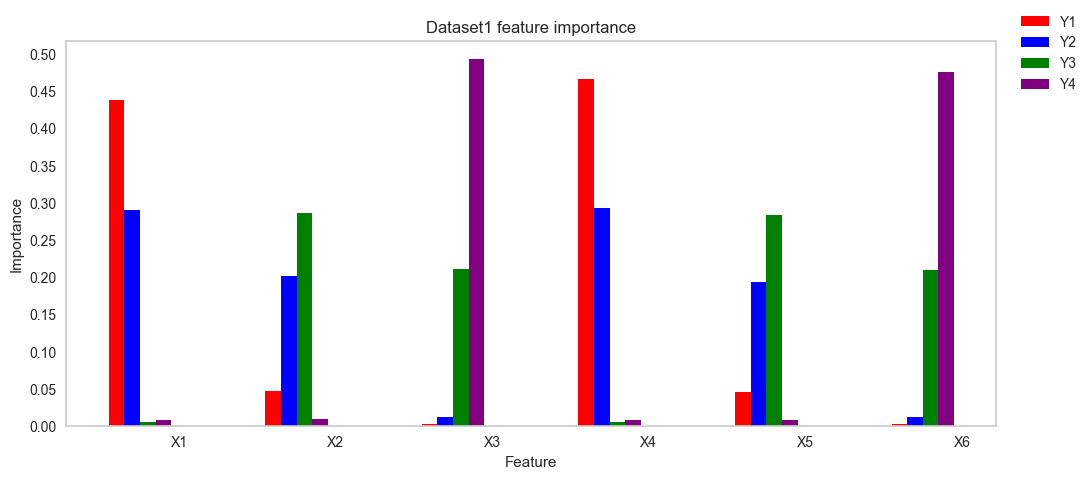

In [48]:
xvalues = np.arange(1, len(data_columns) + 1)
names_cols = list(map(str, data_columns))

fig, ax = plt.subplots(figsize=(12, 5))

ax.set_title("Dataset1 feature importance")
ax.set_xticks(xvalues + 0.3)
ax.set_xticklabels(names_cols)
ax.set_yticks(np.arange(0, 1.00, 0.05))
ax.set_ylabel("Importance")
ax.set_xlabel("Feature")

colors = ["red", "blue", "green", "purple"]
estimators_classifiers = multi.estimators_
for i, val in enumerate(estimators_classifiers):
    ax.bar(xvalues + (i - 1) * 0.1, val.feature_importances_, 0.1, color=colors[i])

ax.legend(y_columns, bbox_to_anchor=(1.1, 1.1))
plt.grid()
plt.show()

Los resultados que obtenemos en este gráfico de la importancia de los atributos se parece mucho al que hemos obtenido anteriormente.

En este observamos que al tener un conjunto de datos mayor

#### Hacemos el plot diferencia de los dos que hemos realizado anteriormente

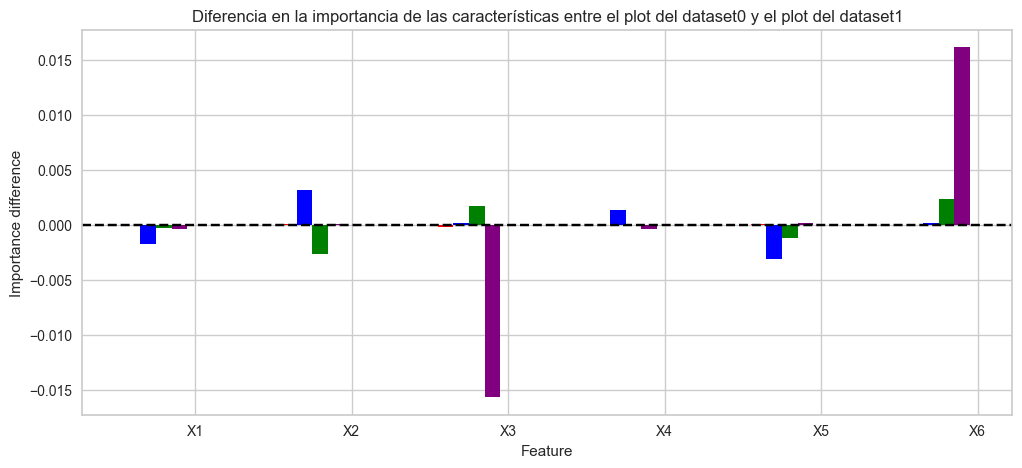

In [87]:
# feature importance values plot 1
feature_importances_plot1 = []
for val in multi0.estimators_:
    feature_importances_plot1.append(val.feature_importances_)

# feature importance values plot 2
feature_importances_plot2 = []
for val in multi.estimators_:
    feature_importances_plot2.append(val.feature_importances_)
    
# differencia entre las dos listas
difference = [x2 - x1 for (x1, x2) in zip(feature_importances_plot2, feature_importances_plot1)]

fig, ax = plt.subplots(figsize=(12, 5))

ax.set_title("Diferencia en la importancia de las características entre el plot del dataset0 y el plot del dataset1")
ax.set_xticks(xvalues + 0.3)
ax.set_xticklabels(names_cols)
ax.set_ylabel("Importance difference")
ax.set_xlabel("Feature")

colors = ["red", "blue", "green", "purple"]
for i, val in enumerate(difference):
    ax.bar(xvalues + (i - 1) * 0.1, val, 0.1, color=colors[i])

ax.axhline(y=0, color='black', linestyle='dashed')

plt.show()

### d) ¿Por qué creéis que los resultados de estos clasificadores son mejores que los del clasificador k vecinos más cercanos? ¿Por qué creéis que necesitamos menos ejemplos para estos resultados?

En primer lugar, para poder atacar las preguntas que se nos pleantean, es importante destacar que nuestros datos son separables ya que sumando dígitos distintos o los mismos en distinto orden podemos obtener unos mismos resultados. Esto quiere decir que nuestros datos quedan divididos en distintas particiones que tienen el mismo valor de suma de salida. Esto ejemplificado nos queda como:

Sumando: 0+0 = 0 </br>
Sumando: 0+1 o 1+0 = 1 </br>
Sumando: 0+2 o 1+1 o 2+0 = 2 </br>
Sumando: 0+3 o 1+2 o 2+1 o 3+0 = 3 </br>
... </br>
Sumando: 0+9 o 1+8 o 2+7 o 3+6 o 4+5 o 5+4 o 6+3 o 7+2 o 8+1 o 9+0 = 9 </br>
... </br>
Sumando: 9+9 = 18 </br>

Como podemos ver, logramos tener hasta **19 particiones** distintas de esta forma.

Si atacamos la pregunta que se nos pide: **Por qué creéis que los resultados de estos clasificadores son mejores que los del clasificador k vecinos más cercanos?**

Creemos que obtenemos mejores resultados con las SVM que con los que obtuvimos con los modelos de KNN porque las SVM son capaces de separar mejor nuestros conjuntos de datos. Esto es así ya que usando el kernel de función de base radial (RBF) en las SVM, puede transformar los datos en un espacio de mayor dimensión y encontrar unos mejores hiperplanos separables. 

Asimismo es importante destacar que, como nuestro conjunto de datos no contiene variaciones aleatorias o errores en los datos, nuestras máquinas de soporte vectorial puedan identificar mejores planos separables (es decir, límites de decisión que puedan clasificar con precisión los datos) que separen de forma correcta los datos y pueden encontrar patrones y hacer predicciones precisas. 

Respondiendo a la segunda pregunta: **¿Por qué creéis que necesitamos menos ejemplos para estos resultados?**

Como bien sabemos para que los modelos KNN funcionen bien necesitamos que nuestros datos estén muy estructurados y que haya una separación clara entre las clases, además de que dispongamos de bastantes muestras para que puedan funcionar de forma aceptable; si nuestros datos están muy desestructurados y no tienen una separación clara entre las clases necesitaremos una mayor cantidad de ejemplos para clasificar y predecir con precisión nuestra variable objetivo. Así que para que nuestros modelos de k vecinos más cercanos funcionen bien necesitamos darle un alto número de ejemplos con cierta calidad y representatividad de los ejemplos para que tengamos un buen desempeño de los modelos.

Por otro lado, nuestras SVM puede funcionar muy bien con una cantidad relativamente pequeña de ejemplos. Estas SVM funcionan al encontrar el hiperplano en un espacio de alta dimensión que separa al máximo las clases, y que preserva al máximo las distancias entre las muestras y el hiperplano. Esto permite que las SVM clasifiquen i predigan efectivamente la variable objetivo con una número más pequeño de ejemplos.